# Task Overview

Your task will be to implement a *RevNet* (Reversible Residual Network) – a variant of ResNet where each layer's activations can be reconstructed exactly from the next layer. Therefore, the activations for most layers need not be stored in memory to perform backpropagation.

You can find more information about RevNet here: [link](https://arxiv.org/pdf/1707.04585.pdf)

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (10pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 2pt implement the mini-batch update
  - 5pt implement the backpropagation (note: if you implement backpropagation example-by-example instead of whole minibatch at once, you will get maximum of 2pt for this part)
2. Train the models (find proper hyperparameters). Visualize training of your best model (plot training and test loss/accuracy in time). Your model should reach at least 96% accuracy. Use clear ml for logging your scores. Make a comparison of memory usage for your network and the network you implemented in lab 3.
  - 1pt for accuracy above 96%
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.



## Potential questions, clarifications
- Q: Can I save the output of the last layer before classification (a -> 10)?
  - Yes.
- Q: MNIST has only one channel, how do I split that into two groups for implementing ReVNet blocks?
  - You can split activations into two groups, so if a layer has size $a$ you can split it into $2 \cdot a/2$.
- Q: Can I modify code of ReVNet outside #Your code goes here # to include logging?
  - Yes, in ReVNet.SGD

# Imports

In [1]:
!pip install clearml --quiet
!pip install memory-profiler --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
from torchvision import datasets, transforms
from clearml import Task
import plotly.express as px

In [3]:
%load_ext memory_profiler

# Dataset loading


In [4]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2023-11-26 15:09:04--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.216.88, 54.231.132.96, 54.231.165.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.216.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  6.66MB/s    in 1.6s    

2023-11-26 15:09:07 (6.66 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [5]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [6]:
### Your code goes here ###
from clearml import Task

web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'
access_key = 'AE7OHTUR6TJJIF52BFUM'
secret_key = '0OQDX1AkMJsL3FtueS0u8nRkdH18Ex3ZYzAVNmX5D45JLGeu4C'

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)
###########################

# Network definition (as in laboratory 3)


In [7]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
            else:
                print("Epoch: {0}".format(j))


# ReVNet definition

RevNets are composed of a series of reversible blocks. The channels (in case of MNIST: activations) in each layer are partitioned into two groups (two vectors), denoted $x_1$ and $x_2$.

Forward: Each reversible block takes inputs ($x_1$, $x_2$) and produces outputs produces outputs ($y_1$, $y_2$) using functions F and G (the *residuals*). In this task, implement F and G as MLP layers.

$z_1 = x_1 + \mathcal{F}(x_2)$

$y_2 = x_2 + \mathcal{G}(z_1)$

$y_1 = z_1$

The expressions $y_1$ and $z_1$ have the same value, but they are separate nodes in the computation graph, with $y_2$ depending on $z_1$, not $y_1$. We use this distinction so that we can describe gradient computations in two steps: $∂ℒ/∂y_1$ is the derivative of the loss over $y_1$ when $y_2$ is a fixed constant, while $∂ℒ/∂z_1$ is the derivative over $z_1$, which influences the loss through both y1 and y2.

Reverse: Each layer’s activations can be reconstructed from the next layer’s activations as follows:

$x_2 = y_2 - \mathcal{G}(y_1)$

$x_1 = y_1 - \mathcal{F}(x_2)$

Backpropagation is described in the algorithm below, ($y_1$, $y_2$).
$\bar{y_1}$, $\bar{y_2}$ is the gradient of the loss over $y_1$ and $y_2$, respectively


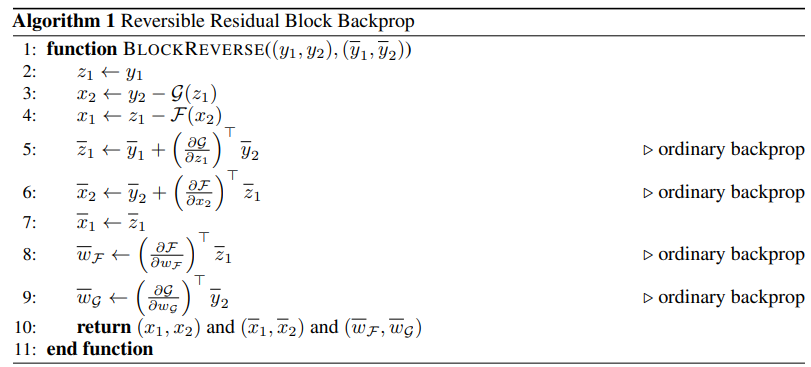

In [57]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))
def softmax(x):
    ### Your code goes here ###
    softmax = np.exp(x)
    return softmax / softmax.sum(axis = 0)
    ###########################

def cross_entropy(x, y):
    ### Your code goes here ###
    # x- output of the NN after softmax(10, no. of examples)
    # y - truth, (no. of examples, 10)
    y = y.T
    n = x.shape[1]
    corr = np.argmax(y,axis=0)
    log_likelihood = np.log(x[corr,range(n)])
    return -np.sum(log_likelihood)/n
    ###########################


class ReVNet(object):
  def __init__(self, sizes):
    # initialize biases and weights with random normal distr.
    # weights are indexed by target node first
    # sizes should be in form (mnist_size, a, a, a, ...,  a, 10)
    # IMPORTANT: use at least one layer of size a -> a
    ### Your code goes here ###

    self.sizes = sizes
    self.num_layers = len(sizes) - 1
    self.num_rev_blocks = len(sizes) - 3
    # in this implementation, F and G are a single layers of a size a/2
    a_size = sizes[1]

    residuals_biases = [[np.random.randn(a_size//2,1) for i in range(2)] for x in range(len(sizes)-3)]


    self.biases = [np.random.randn(sizes[1],1)] + residuals_biases + [np.random.randn(sizes[-1],1)]

    residuals_weights = [[np.random.normal(loc=0.0, scale=np.sqrt(2/a_size), size=(a_size//2,a_size//2)) for i in range(2)] for x in range(len(sizes)-3)]

    self.weights = [np.random.normal(loc=0.0, scale=np.sqrt(2/(sizes[1]+sizes[0])),size=(sizes[1],sizes[0]))] + residuals_weights \
                    + [np.random.normal(loc=0.0, scale=np.sqrt(2/(sizes[-1]+sizes[-2])),size=(sizes[-1],sizes[-2]))]
    ###########################

  def feedforward(self, a):
    # Run the network
    ### Your code goes here ###
    a = a.T

    #pass through the first (subsampling) layer
    a = sigmoid(np.matmul(self.weights[0],a)+self.biases[0])
    #divide a into x_1 and x_2 for revblocks (x_2 is the upper half)
    x_2 = a[:a.shape[0]//2]
    x_1 = a[a.shape[0]//2:]

    #pass through the series of RevBlocks
    for b,w in zip(self.biases[1:-1],self.weights[1:-1]):
      y_1 = x_1 + sigmoid(np.matmul(w[0], x_2) + b[0])
      y_2 = x_2 + sigmoid(np.matmul(w[1], y_1) + b[1])

      x_1 = y_1
      x_2 = y_2
    #join x_2 and x_1 into an a for the last regular layer
    a = np.concatenate((x_2,x_1),axis=0)

    #pass through the last layer
    a = softmax(np.matmul(self.weights[-1],a)+self.biases[-1])

    return(a)
    ###########################

  def update_mini_batch(self, x_mini_batch, y_mini_batch, eta):
    # Update networks weights and biases by applying a single step
    # of gradient descent using backpropagation to compute the gradient.
    # The gradient is computed for a mini_batch.
    # eta is the learning rate
    ### Your code goes here ###
    nabla_b, nabla_w = self.backpropagation(x_mini_batch,y_mini_batch)

    # calculate updates for the first layer

    new_weights = [self.weights[0]-(eta/len(x_mini_batch))*nabla_w[0]]
    new_biases = [self.biases[0]-(eta/len(x_mini_batch))*nabla_b[0]]

    # calculate new parameters of residual functions

    for w,nw in zip(self.weights[1:-1], nabla_w[1:-1]):
      new_weights.append([w[i]-(eta/len(x_mini_batch))*nw[i] for i in range(2)])

    for b,nb in zip(self.biases[1:-1], nabla_b[1:-1]):
      new_biases.append([b[i]-(eta/len(x_mini_batch))*nb[i] for i in range(2)])

    # calculate new params for the last layer
    new_weights.append(self.weights[-1]-(eta/len(x_mini_batch))*nabla_w[-1])
    new_biases.append(self.biases[-1]-(eta/len(x_mini_batch))*nabla_b[-1])

    self.weights = new_weights
    self.biases = new_biases

    ###########################


  def backpropagation(self, x, y):
    ### Your code goes here ###

    y = y.T
    X_in = x.T

    # pass through first (mnist size -> a) layer

    a = sigmoid(np.matmul(self.weights[0],X_in)+self.biases[0])

    x_2 = a[:a.shape[0]//2]
    x_1 = a[a.shape[0]//2:]

    # pass through the series of RevBlocks

    for b,w in zip(self.biases[1:-1],self.weights[1:-1]):

      y_1 = x_1 + sigmoid(np.matmul(w[0], x_2) + b[0])
      y_2 = x_2 + sigmoid(np.matmul(w[1], y_1) + b[1])

      x_1 = y_1
      x_2 = y_2

    # join x_2 and x_1 into an a for the last regular layer
    a = np.concatenate((x_2,x_1),axis=0)

    # pass through the last (softmax) layer
    f_last = np.matmul(self.weights[-1],a)+self.biases[-1]

    # backward pass
    # first the last layer

    dLdf = self.cost_derivative(f_last, y)
    dLdfs = [dLdf]
    dLdg = np.matmul(self.weights[-1].T, dLdf)

    # save gradients for W and B, they will be reversed at the end

    dLdWs = [np.matmul(dLdf,a.T)]
    dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1)]

    # now go back through the sequence of RevBlocks
    dLdy_2 = dLdg[:dLdg.shape[0]//2]
    dLdy_1 = dLdg[dLdg.shape[0]//2:]

    for b,w in zip(reversed(self.biases[1:-1]),reversed(self.weights[1:-1])):
      b_F, b_G = b
      w_F, w_G = w
      z_1 = y_1
      x_2 = y_2 - sigmoid(np.matmul(w_G, z_1) + b_G)
      x_1 = z_1 - sigmoid(np.matmul(w_F, x_2) + b_F)

      G_z1 = sigmoid(np.matmul(w_G, z_1) + b_G)
      dGdz_1 = np.matmul(np.multiply(G_z1,1-G_z1).T,w_G.T)
      dLdz_1 = dLdy_1 + np.multiply(dGdz_1.T,dLdy_2)

      F_x2 = sigmoid(np.matmul(w_F, x_2) + b_F)
      dFdx_2 = np.matmul(np.multiply(F_x2,1-F_x2).T,w_F.T)
      dLdx_2 = dLdy_2 + np.multiply(dFdx_2.T,dLdz_1)

      dLdx_1 = dLdz_1

      # weights gradients
      dFdw_F = np.multiply(np.multiply(F_x2,1-F_x2),x_2)
      dLdw_F = np.matmul(dFdw_F,dLdz_1.T)

      dGdw_G = np.multiply(np.multiply(G_z1,1-G_z1),z_1)
      dLdw_G = np.matmul(dGdw_G,dLdy_2.T)

      # biases gradients
      dFdb_F = np.multiply(F_x2,1-F_x2)
      dLdb_F = np.sum(np.multiply(dFdb_F, dLdz_1),axis=1).reshape(dFdb_F.shape[0],1)

      dGdb_G = np.multiply(G_z1,1-G_z1)
      dLdb_G = np.sum(np.multiply(dGdb_G, dLdy_2),axis=1).reshape(dGdb_G.shape[0],1)

      # save gradients of the parameters
      dLdWs.append([dLdw_F,dLdw_G])
      dLdBs.append([dLdb_F,dLdb_G])

      # update variables for the next (previous) layer
      y_1 = x_1
      y_2 = x_2
      dLdy_1 = dLdx_1
      dLdy_2 = dLdx_2

    # calculate for the first layer (784 -> a)

    g = np.concatenate((y_2,y_1),axis=0)
    dLdg = np.concatenate((dLdy_2,dLdy_1),axis=0)
    dLdf = np.multiply(dLdg,np.multiply(g,1-g))
    dLdBs.append(np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1))
    dLdWs.append(np.matmul(dLdf,X_in.T))

    return(dLdBs[::-1],dLdWs[::-1])

    ###########################

  def cost_derivative(self, output_activations, y):
      softmax = np.exp(output_activations)
      softmax = softmax / softmax.sum(axis = 0)
      return softmax - y

  def evaluate(self, x_test_data, y_test_data):
      NN_out = self.feedforward(x_test_data)
      pred = np.argmax(NN_out,axis=0)
      corr = np.argmax(y_test_data,axis=1).T
      loss = cross_entropy(NN_out,y_test_data)
      return np.mean(pred==corr), loss


  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None,task=None):
    if task:
        config = {
            'sizes': self.sizes,
            'epochs': epochs,
            'mini_batch_size': mini_batch_size,
            'eta': eta
        }
        task.mark_started()
        logger = task.get_logger()
        task.connect(config)
    x_train, y_train = training_data
    if test_data:
        x_test, y_test = test_data
    for j in range(epochs):
        for i in range(x_train.shape[0] // mini_batch_size):
            x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
            y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
            self.update_mini_batch(x_mini_batch, y_mini_batch, eta)

        train_acc,train_loss = self.evaluate(x_train, y_train)
        print("Epoch: {0}, Train Accuracy: {1}, Train Loss: {2}".format(j, train_acc, train_loss))

        if task:
            logger.report_scalar(title='Loss', series='Train', iteration=j, value=train_loss)
            logger.report_scalar(title='Accuracy', series='Train', iteration=j, value=train_acc)

        if test_data:
            test_acc,test_loss = self.evaluate(x_test, y_test)
            print("Test set: Accuracy: {0}, Loss: {1}".format(test_acc, test_loss))

            if task:
                logger.report_scalar(title='Loss', series='Test', iteration=j, value=test_loss)
                logger.report_scalar(title='Accuracy', series='Test', iteration=j, value=test_acc)
        else:
            print("Epoch: {0}".format(j))

    if task:
        task.upload_artifact(name='weights', artifact_object=self.weights)
        task.upload_artifact(name='biases', artifact_object=self.biases)
        task.mark_completed()
        # task.close()

# Train the network

In [65]:
 ### Your code goes here ###

configs=[
    {
    'sizes': [784,100,100,10],
    'epochs': 100,
    'mini_batch_size': 100,
    'eta': 0.1
    },
    {
    'sizes': [784,50,50,50,10],
    'epochs': 100,
    'mini_batch_size': 100,
    'eta': 1
    },
    {
    'sizes': [784,100,100,10],
    'epochs': 50,
    'mini_batch_size': 100,
    'eta': 1
    },
    {
    'sizes': [784,30,30,10],
    'epochs': 200,
    'mini_batch_size': 100,
    'eta': 0.5
    }
    ]
for config in configs:
    task = Task.create(project_name="DNN_hw1", task_name="ReVNet_logging")
    network = ReVNet(config['sizes'])
    network.SGD((x_train, y_train), epochs=config['epochs'], mini_batch_size=config['mini_batch_size'], eta=config['eta'], test_data=(x_test, y_test),task=task)
    task.close()
###########################

Epoch: 0, Train Accuracy: 0.8565333333333334, Train Loss: 0.49933054824591383
Test set: Accuracy: 0.8666, Loss: 0.483220952547359
Epoch: 1, Train Accuracy: 0.8906666666666667, Train Loss: 0.37413342640625585
Test set: Accuracy: 0.897, Loss: 0.3604233540358338
Epoch: 2, Train Accuracy: 0.9030666666666667, Train Loss: 0.32897081263748995
Test set: Accuracy: 0.9088, Loss: 0.3177169672713571
Epoch: 3, Train Accuracy: 0.9106166666666666, Train Loss: 0.3030394933570681
Test set: Accuracy: 0.9139, Loss: 0.29394532433222875
Epoch: 4, Train Accuracy: 0.91625, Train Loss: 0.2843546864988851
Test set: Accuracy: 0.9175, Loss: 0.2771656908770213
Epoch: 5, Train Accuracy: 0.9211333333333334, Train Loss: 0.26910439578796796
Test set: Accuracy: 0.9206, Loss: 0.2635677953540086
Epoch: 6, Train Accuracy: 0.9252, Train Loss: 0.25577927192152217
Test set: Accuracy: 0.9254, Loss: 0.2516501295010253
Epoch: 7, Train Accuracy: 0.9293333333333333, Train Loss: 0.24373174239336373
Test set: Accuracy: 0.9295, Los

# Training plots for the best training

Best test accuracy for the model with config: {'General/sizes': '[784, 100, 100, 10]', 'General/epochs': '100', 'General/mini_batch_size': '100', 'General/eta': '0.1'}
Retrived best model evaluation:
Test Accuracy: 0.9766, Test Loss: 0.0778569203688519


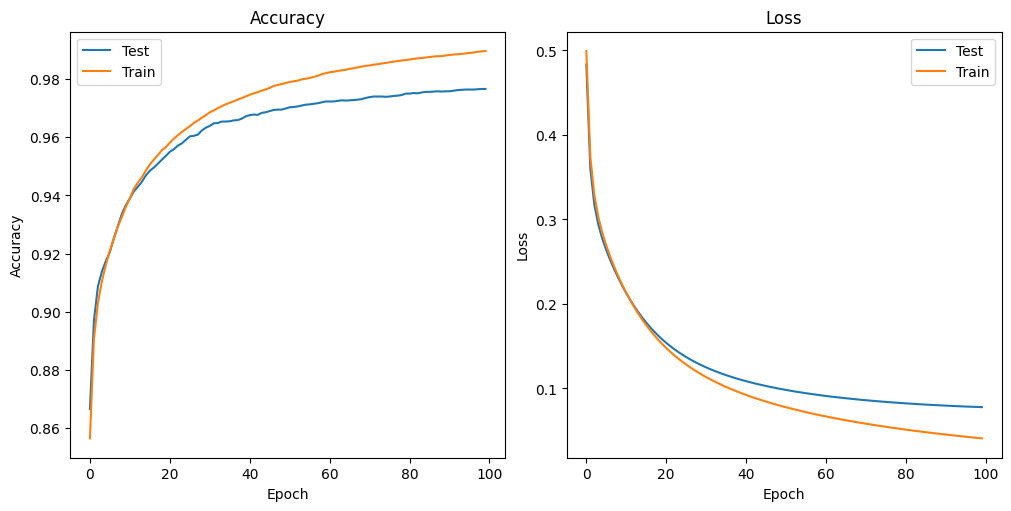

In [81]:
 ### Your code goes here ###
task = Task.get_tasks(
    project_name='DNN_hw1',
    tags = ['top_accuracy']
)[0]

metrics = task.get_reported_scalars()
weights = task.artifacts['weights'].get()
biases = task.artifacts['biases'].get()
config = task.get_parameters()
sizes = [int(i) for i in config['General/sizes'][1:-1].split(', ')]

print("Best test accuracy for the model with config: {0}".format(config))
best_RN = ReVNet(sizes)
best_RN.weights = weights
best_RN.biases = biases
acc,loss = best_RN.evaluate(x_test,y_test)
print('Retrived best model evaluation:')
print("Test Accuracy: {0}, Test Loss: {1}".format(acc, loss))

test_acc = metrics['Accuracy']['Test']['y']
train_acc = metrics['Accuracy']['Train']['y']

test_loss = metrics['Loss']['Test']['y']
train_loss = metrics['Loss']['Train']['y']

x = metrics['Accuracy']['Test']['x']


import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,layout="constrained",figsize=(10, 5))

ax1.set_title('Accuracy')
ax1.plot(x, test_acc, label='Test')
ax1.plot(x, train_acc, label='Train')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.set_title('Loss')
ax2.plot(x, test_loss, label='Test')
ax2.plot(x, train_loss, label='Train')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()


###########################

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [80]:
 ### Your code goes here ###
sizes = [784,30,30,30,10]

NN = Network(sizes)
print("NN from lab 3")
%memit NN.SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=0.3, test_data=(x_test, y_test) )
print("-"*40)

RN = ReVNet(sizes)
print('ReVNet')
%memit RN.SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=.3, test_data=(x_test, y_test))
print("-"*40)
###########################

NN from lab 3
Epoch: 0, Accuracy: 0.3819
peak memory: 1176.55 MiB, increment: 0.00 MiB
----------------------------------------
ReVNet
Epoch: 0, Train Accuracy: 0.8938833333333334, Train Loss: 0.35905458954242075
Test set: Accuracy: 0.8986, Loss: 0.3470738040017471
peak memory: 1215.25 MiB, increment: 38.71 MiB
----------------------------------------
